In [11]:
from os import listdir
import xarray
import cftime
import numpy as np

import sys
sys.path.append('/projects/dgs/persad_research/heat_research/aerosol-heatwaves/scripts/')
import paths

In [50]:
def compute_threshold(temperature_data: xarray.DataArray, percentile:float=0.9, temp_path="No path provided.", control_path="No path provided.") -> xarray.DataArray:
    """
    ADD MORE INFO
    
    percentile_range -> days before and after the day of intereset when computing the percentile to include into the pool
    """
    print("Initialize")
    
    init_year = temperature_data.time.values[0].year
    year_range = temperature_data.time.values[-1].year - init_year + 1
    
    annual_threshold = np.zeros((365, temperature_data.lat.size, temperature_data.lon.size))
    
    day_of_year = np.zeros((365, year_range), int)

    for index in range(temperature_data.time.values.size):
        date = temperature_data.time.values[index]
        day_of_year[date.dayofyr-1, date.year - init_year] = index
    print("Second stage")
    
    for index in range(day_of_year.shape[0]):
        print(index, end=", ")
        
        init_i = (index - 7) % day_of_year.shape[0]
        fin_i = (index + 8) % day_of_year.shape[0]
        
        if fin_i > init_i:
            indices = np.array([day_of_year[i] for i in range(init_i, fin_i)]).flatten()
        else:
            both_parts = [day_of_year[i] for i in range(init_i, day_of_year.shape[0])] + [day_of_year[i] for i in range(0, fin_i)]
            indices = np.array(both_parts).flatten()
        
        quantiles = np.quantile(np.array([temperature_data.values[i] for i in indices]), percentile, axis=0, method="midpoint")
        annual_threshold[index] = quantiles
    
    return xarray.Dataset(
        data_vars=dict(
            threshold=(["day", "lat", "lon"], annual_threshold),
        ),
        coords=dict(
            lon=(["lon"], temperature_data.lon.values),
            lat=(["lat"], temperature_data.lat.values),
            day=np.arange(0, 365),
        ),
        attrs={
            "description":f"{int(percentile*100)}th percentile temperatures.",
            "temperature dataset path": temp_path,
            "control dataset path": control_path
        },
    )



In [13]:
#path = '/projects/dgs/persad_research/heat_research/old_data/TREFHTMN/CONTROL/download/b.e11.B1850C5CN.f09_g16.005.cam.h1.TREFHTMN.19000101-19991231.nc'
path = "/projects/dgs/persad_research/heat_research/data/TREFHTMN/CONTROL/b.e11.B1850C5CN.f09_g16.005.cam.h1.TREFHTMN.17000101-22001231.nc"
control_trefhtmn = xarray.open_dataset(path)["TREFHTMN"]
control_trefhtmn

<xarray.DataArray 'TREFHTMN' (time: 182865, lat: 192, lon: 288)>
[10111703040 values with dtype=float32]
Coordinates:
  * time     (time) object 1700-01-02 00:00:00 ... 2201-01-01 00:00:00
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    units:         K
    long_name:     Minimum reference height temperature over output period
    cell_methods:  time: minimum

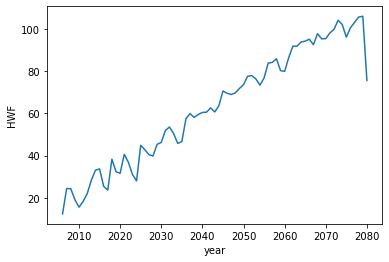

In [17]:
from os import listdir

HEAD_DIR = "/projects/dgs/persad_research/heat_research/data/OUTPUT/METRICS/TREFHTMN/ALL/"
path = HEAD_DIR + 'b.e11.BRCP85C5CNBDRD.f09_g16.005.cam.h1.TREFHTMN.20060101-20801231.nc_hw.nc'

xarray.open_dataset(path)["HWF"].mean(dim="lat").mean(dim="lon").plot()

In [214]:
# control_threshold.to_netcdf("/projects/dgs/persad_research/heat_research/testing/new_control.nc")
control_threshold = xarray.open_dataset("/projects/dgs/persad_research/heat_research/testing/new_control.nc")["threshold"]
control_threshold

<xarray.DataArray 'threshold' (day: 365, lat: 192, lon: 288)>
[20183040 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * day      (day) int64 0 1 2 3 4 5 6 7 8 ... 357 358 359 360 361 362 363 364

In [132]:
old_threshold = xarray.open_dataset("/projects/dgs/persad_research/heat_research/testing/old_threshold.nc")
old_threshold["tnpct"]

<xarray.DataArray 'tnpct' (day: 365, lat: 192, lon: 288)>
[20183040 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: day
Attributes:
    long_name:    tmin percentile
    units:        degC
    description:  90th percentile of 1901-1999

Text(0.5, 0, 'Time (Day of Year)')

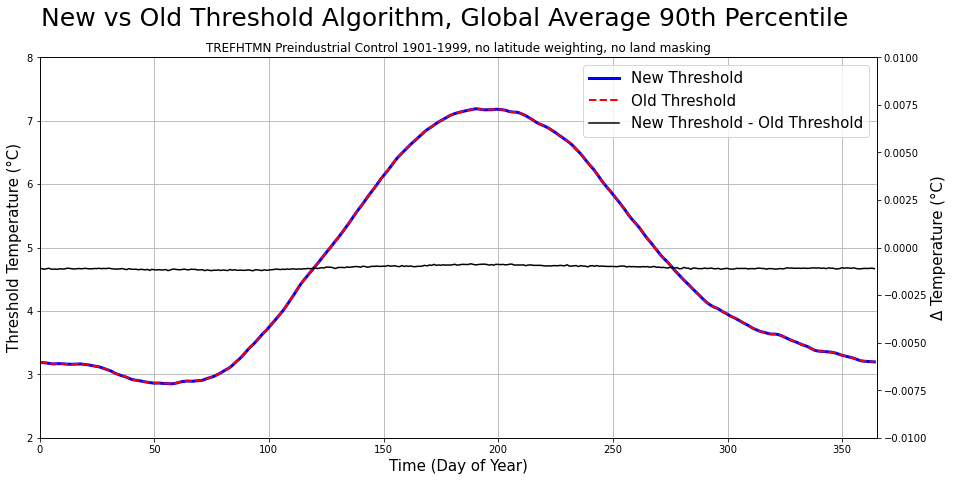

In [487]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

f, ax = plt.subplots(1, 1, figsize=(15, 7), facecolor='w')

(control_threshold.mean(dim="lat").mean(dim="lon") - 273.15).plot(ax=ax, color="Blue", label="New Threshold", linewidth=3)
old_threshold["tnpct"].mean(dim="lat").mean(dim="lon").plot(ax=ax, color="Red", label="Old Threshold", linestyle="--", linewidth=2)
ax.plot([0, 0], [0, 0], color="Black", label="New Threshold - Old Threshold")

axx = ax.twinx()

((control_threshold.mean(dim="lat").mean(dim="lon") - 273.15) - old_threshold["tnpct"].mean(dim="lat").mean(dim="lon")).plot(ax=axx, color="Black")

f.suptitle("New vs Old Threshold Algorithm, Global Average 90th Percentile", fontsize=25)
ax.set_title("TREFHTMN Preindustrial Control 1901-1999, no latitude weighting, no land masking", fontsize=12)


ax.legend(fontsize=15)
ax.grid()
ax.set_xlim(0, 365)
ax.set_ylim(2, 8)
axx.set_ylim(-0.01, 0.01)
ax.set_ylabel("Threshold Temperature (°C)", fontsize=15)
axx.set_ylabel("Δ Temperature (°C)", fontsize=15)
ax.set_xlabel("Time (Day of Year)", fontsize=15)

In [204]:
trefhtmn_all_0 = xarray.open_dataset("/projects/dgs/persad_research/heat_research/old_data/TREFHTMN/ALL/concatenated/trefhtmin_all_0.nc")["TREFHTMN"]
trefhtmn_all_0

<xarray.DataArray 'TREFHTMN' (time: 58765, lat: 192, lon: 288)>
[3249469440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1920-01-01 00:00:00 ... 2080-12-31 00:00:00
Attributes:
    units:         K
    long_name:     Minimum reference height temperature over output period
    cell_methods:  time: minimum

In [522]:
xarray.Dataset

xarray.core.dataset.Dataset

In [525]:
def indicate_hot_days(temp_ds, threshold):
    """
    Marks days in the temperature input that exceed the daily thresholds.
    
    Keyword arguments:
    temp_ds -- temperature dataset to use as input (xarray.DataArray)
    threshold -- threshold dataset to compare the input against (xarray.DataArray)
    """
    hot_days = np.zeros(temp_ds.values.shape, dtype=int)
    
    for index in range(temp_ds.time.values.size):
        day_number = temp_ds.time.values[index].dayofyr
        hot_days[index] = (temp_ds.values[index] > threshold.values[day_number-1])*(temp_ds.values[index] >= 273.15)

    return hot_days


def index_heatwaves(timeseries, max_break=1, min_duration=3):
    """
    Identifies the heatwaves in the timeseries using the specified heatwave definition
    
    Keyword arguments:
    timeseries -- integer array of ones and zeros where ones indicates a hot day (numpy.ndarray)
    max_break -- the maximum number of days between hot days within one heatwave event (default 1)
    min_duration -- the minimum number of hot days to constitute a heatwave event, including after breaks (default 3)
    """
    timeseries = np.pad(timeseries, 1)
    
    diff_indices = np.where(np.diff(timeseries) != 0)[0] + 1

    in_heatwave = False
    current_hw_index = 1

    hw_indices = np.zeros(timeseries.shape, dtype=np.short)

    broken = False
    for i in range(diff_indices.shape[0]-1):
        index = diff_indices[i]
        next_index = diff_indices[i+1]
        
        if timeseries[index] == 1 and in_heatwave:
            hw_indices[index:next_index] = current_hw_index
        elif timeseries[index] == 0 and in_heatwave and next_index-index <= max_break and not broken:
            hw_indices[index:next_index] = current_hw_index
            broken = True
        elif timeseries[index] == 1 and not in_heatwave and next_index-index >= min_duration:
            in_heatwave = True
            hw_indices[index:next_index] = current_hw_index
        elif in_heatwave:
            current_hw_index += 1
            in_heatwave = False
            broken = False
    return timeseries[1:-1]*hw_indices[1:-1]


#def compute_metrics(temp_ds, control_threshold, temp_path="No path provided.", control_path="No path provided."):
temp_ds = trefhtmn_all_0
control_threshold = control_threshold

hot_days = indicate_hot_days(temp_ds, control_threshold)
indexed_heatwaves = np.zeros(hot_days.shape, dtype=np.short)

vectorized_index_hw = np.vectorize(index_heatwaves)

indexed_heatwaves = index_heatwaves(hot_days)

num_index_heatwaves = indexed_heatwaves > 0
years = temp_ds.time.values[-1].year - temp_ds.time.values[0].year + 1

south_hemisphere = np.ones((int(temp_ds.shape[1]/2), temp_ds.shape[2]), dtype=int)
south_hemisphere.resize((temp_ds.shape[1], temp_ds.shape[2]))
north_hemisphere = 1 - south_hemisphere

hwf = np.zeros((years, indexed_heatwaves.shape[1], indexed_heatwaves.shape[2]), dtype=int)
for index in range(0, years):
    # SHS = (304,455)
    # SHW = (121,274)
    north_lower, north_upper = (365*index + 121, 365*index + 274)
    south_lower, south_upper = (365*index + 304, 365*index + 455)

    hwf[index] = north_hemisphere*np.sum(num_index_heatwaves[north_lower:north_upper], axis=0) + south_hemisphere*np.sum(num_index_heatwaves[south_lower:south_upper], axis=0)

meta = {
        "metrics description": f"90th percentile heatwave metrics.",
        "temperature dataset path": "none",
        "control dataset path": "none",
}
for key in control_threshold.attrs:
    meta[f"threshold-{key}"] = control_threshold.attrs[key]

new_hwf = xarray.Dataset(
    data_vars=dict(
        HD=(["time", "lat", "lon"], hot_days),
        HWI=(["time", "lat", "lon"], indexed_heatwaves),
        HWF=(["year", "lat", "lon"], hwf)
    ),
    coords=dict(
        lon=(["lon"], temp_ds.lon.values),
        lat=(["lat"], temp_ds.lat.values),
        year=np.arange(temp_ds.time.values[0].year, temp_ds.time.values[-1].year+1),
        time=temp_ds.time.values
    ),
    attrs=meta,
    )

#new_hwf = compute_metrics(trefhtmn_all_0, control_threshold["threshold"])
new_hwf

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [248]:
old = old_hwf.sel(lat=new_hwf.lat[0]).sel(lon=new_hwf.lon[160]).values
new = new_hwf["HWF"].sel(lat=new_hwf.lat[0]).sel(lon=new_hwf.lon[160]).values
print(old[140])
print(new[140])

0.0
68


In [296]:
mn_path = "/projects/dgs/persad_research/heat_research/old_data/TREFHTMN/ALL/concatenated/trefhtmin_all_0.nc"
mx_path = "/projects/dgs/persad_research/heat_research/old_data/TREFHTMX/ALL/concatenated/trefhtmax_all_0.nc"
control_path = "/projects/dgs/persad_research/heat_research/testing/modified_control.nc"

texceed = testtesttest("blah", mx_path, mn_path, control_path, "3136")

You didn't specify a land-sea mask. It's faster if you do,so this might take a while.


In [7]:
import time 
import numpy as np
ds = np.random.random((10000, 100, 100))
start = time.time()
np.quantile(ds, 0.9, axis=0, method="midpoint")
dt = time.time() - start
dt

3.6696698665618896

In [9]:
ds = np.random.random((10000, 100, 100))
start = time.time()
np.quantile(ds, 0.9, axis=0, method="nearest")
dt = time.time() - start
dt

3.474384307861328

In [442]:
(new_hwf["HWF"].sel(lat=new_hwf.lat[lati]).sel(lon=new_hwf.lon[loni]).values - old_hwf.sel(lat=new_hwf.lat[lati]).sel(lon=new_hwf.lon[loni]).values)[67]

2.0

In [444]:
new_hwf["HWF"].sel(lat=new_hwf.lat[lati]).sel(lon=new_hwf.lon[loni]).values[67]

38

In [447]:
np.sum(bb_array > 0)

48

In [448]:
# lati = 75
# loni = 230

# index=68
# thres = control_threshold.sel(lat=new_hwf.lat[lati]).sel(lon=new_hwf.lon[loni]).values
# t_array = trefhtmn_all_0.sel(lat=new_hwf.lat[lati]).sel(lon=new_hwf.lon[loni]).values[index*365:(index+1)*365]
# b_array = new_hwf["HD"].sel(lat=new_hwf.lat[lati]).sel(lon=new_hwf.lon[loni]).values[index*365:(index+1)*365]
# bb_array = texceed[index*365:(index+1)*365, lati, loni]
# index_array = new_hwf["HWI"].sel(lat=new_hwf.lat[lati]).sel(lon=new_hwf.lon[loni]).values[index*365:(index+1)*365]

# for i in range(b_array.size):
#     tt = str(np.round(bb_array[i], 3))
#     th = str(np.round(thres[i], 3))
#     tv = str(np.round(t_array[i], 3))
#     print(f"{tt} {b_array[i]} {th} < {tv} {index_array[i]}")
#     # print(f"{bb_array[i] > 0} {index_array[i] > 0}")
    

In [238]:
# for i in range(0, 20):
#     path = f"/projects/dgs/persad_research/heat_research/old_data/heat_output/ALL/1920_1950_control_base/ALL-3136-{i}-tn.nc"
#     s = xarray.open_dataset(path).attrs["tmin_file"][80:]
#     print(f"{i} -> {s}")

# Use 14 for trefhtmn em 0
#path = "/projects/dgs/persad_research/heat_research/old_data/heat_output/ALL/1920_1950_control_base/ALL-3136-14-tn.nc"
path = "old_algo_hw_metrics.nctn.nc"
old_hwf = xarray.open_dataset(path)["HWF_tn90"]
old_hwf.values = old_hwf.values.astype("timedelta64[D]") / np.timedelta64(1, 'D')

#old_hwf2 = old_hwf.copy()

In [511]:
x = np.array([1, 2, 3, 4, 5])
x[0:2]

array([1, 2])

In [515]:
index = 0
temp_ds.time[365*index + 304]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1920, 11, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 1920-11-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

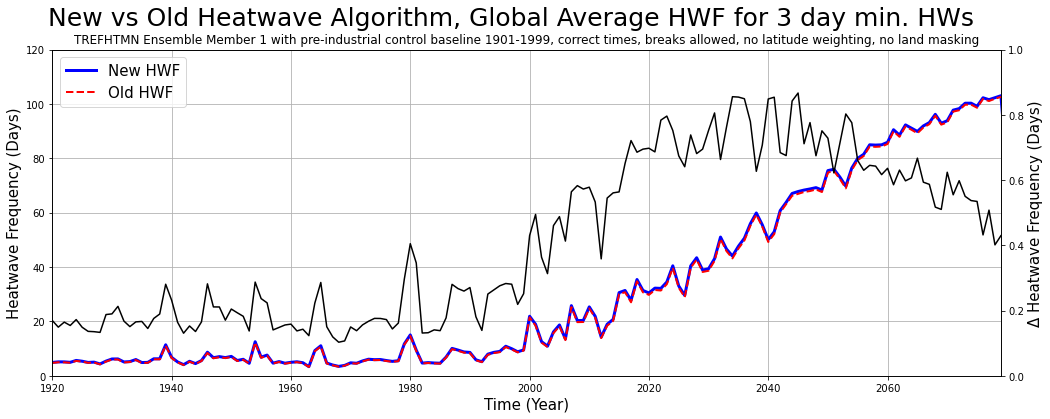

In [516]:
import matplotlib.pyplot as plt

# f, ax = plt.subplots(1, 1, figsize=(15, 7), facecolor='w')

# diff = (new_hwf["HWF"].sel(year=slice(2040,2060)).mean(dim="year") - old_hwf.sel(time=slice(2040,2060)).mean(dim="time"))
# diff = diff.rename("Δ Heatwave Frequency (Days)")

# diff.plot(ax=ax, cmap="seismic", vmax=4, vmin = -4)

# ax.set_title("New Heatwave Metric Algorithm Validation (2040 to 2060 Average)", fontsize=25)
f, ax = plt.subplots(1, 1, figsize=(17, 6), facecolor='w')

new_hwf["HWF"].mean(dim="lat").mean(dim="lon").plot(ax=ax, color="Blue", linewidth=3, label="New HWF")
old_hwf.sel(time=slice(1920, 2079)).mean(dim="lat").mean(dim="lon").plot(ax=ax, color="Red", linewidth=2, linestyle="--", label="Old HWF")

f.suptitle("New vs Old Heatwave Algorithm, Global Average HWF for 3 day min. HWs", fontsize=25)

diff = new_hwf["HWF"].mean(dim="lat").mean(dim="lon").sel(year=slice(1920, 2079)).values - old_hwf.sel(time=slice(1920, 2079)).mean(dim="lat").mean(dim="lon").values

axx = ax.twinx()

axx.plot(new_hwf["HWF"].sel(year=slice(1920, 2079)).year.values, diff, color="Black", label="New HWF - Old HWF")

axx.set_ylim(0, 1)
axx.set_ylabel("Δ Heatwave Frequency (Days)", fontsize=15)

ax.set_title("TREFHTMN Ensemble Member 1 with pre-industrial control baseline 1901-1999, correct times, breaks allowed, no latitude weighting, no land masking", fontsize=12)
ax.set_xlim(1920, 2079)
ax.set_ylim(0, 120)
ax.set_ylabel("Heatwave Frequency (Days)", fontsize=15)
ax.set_xlabel("Time (Year)", fontsize=15)
ax.grid()
ax.legend(fontsize=15)

Text(0.5, 1.0, 'TREFHTMN Ensemble Member 1 with pre-industrial control baseline 1901-1999, correct times, breaks allowed, no land masking')

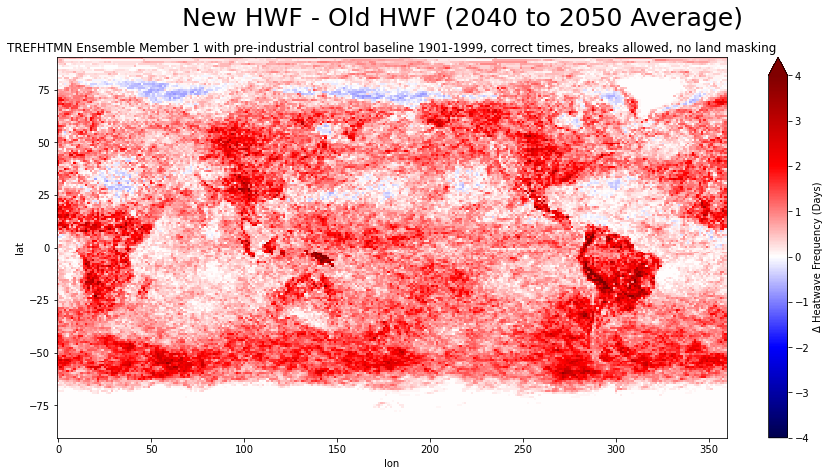

In [518]:
f, ax = plt.subplots(1, 1, figsize=(15, 7), facecolor='w')

diff = (new_hwf["HWF"].sel(year=slice(2040,2050)).mean(dim="year") - old_hwf.sel(time=slice(2040,2050)).mean(dim="time"))
diff = diff.rename("Δ Heatwave Frequency (Days)")

diff.plot(ax=ax, cmap="seismic", vmax=4, vmin = -4)

f.suptitle("New HWF - Old HWF (2040 to 2050 Average)", fontsize=25)
ax.set_title("TREFHTMN Ensemble Member 1 with pre-industrial control baseline 1901-1999, correct times, breaks allowed, no land masking", fontsize=12)


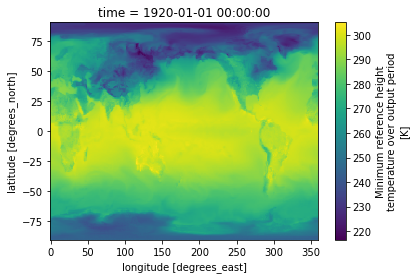

In [181]:
temp_ds = trefhtmn_all_0.sel(time=trefhtmn_all_0.time[0])
temp_ds.plot()

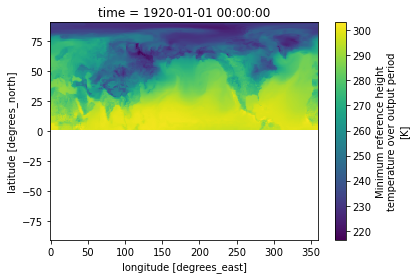

In [192]:
south_hemisphere = np.ones((int(temp_ds.shape[0]/2)+1, temp_ds.shape[1]), dtype=int)
south_hemisphere.resize((temp_ds.shape[0], temp_ds.shape[1]))
north_hemisphere = 1 - south_hemisphere

temp_ds.where(north_hemisphere).plot()